### Quickstart Procgen: Defining Distributions over Functions

In order to evaluate an algorithm over multiple similar instances of the same problem, or construct an environment of diverse training functions for Reinforcement Learning agents, one can easily define distributions over functions through the `haiku.initializers` module. If we define parameters internally in our `Function` and `FunctionWrapper` implementations with a call to `haiku.get_param`, we can control how the parameters should be initialized. This is already the default implementation for all our functions. 

However, some functions are dependent on a stochastic initialization whereas others aren't. The Sphere function does not depend on a PRNGKey, but can e.g., be made dependent through a wrapper like `Translation`. We split up all functions that require a stochastic initialization at the base into the `procgen` module opposed to the `functions` module. This include functions like those sampled from a Gaussian Process Prior.

The syntax for constructing these function is essentially equivalent to `functions` and is already covered in `function_interface.ipynb`. This notebook shortly illustrates the usage for constructing a variety of Gaussian Process Prior samples. At the end we also show an example on how to simulate a non-stationary `Function` instance by using procedurally generated parameters with our API. This format can also be extended to create multi-dimensional output functions and multi-fidelity optimization problems.

In [1]:
import jax
from jax import numpy as jnp

import haiku as hk

import matplotlib.pyplot as plt

from bbox import procgen as px
from bbox import wrappers as wx

from bbox import as_transformed


key = jax.random.PRNGKey(123)

rbf = lambda a, b: jnp.exp(-0.5 * jnp.sum(jnp.square(a - b)))
my_fun = as_transformed(
    px.real.GaussianProcessPrior.partial(kernel=rbf, resolution=100)
)
my_fun = hk.without_apply_rng(my_fun)

params = jax.vmap(my_fun.init, in_axes=(0, None))(jax.random.split(key, num=5), jnp.zeros(2))

# Illustrate that our parameter-containers contains a batch of 5 dimensions.
print(jax.tree_map(jnp.shape, params))

{'PartialGaussianProcessPrior': {'bases': (5, 100), 'shift': (5, 100, 2)}}


In [2]:
x = y = jnp.linspace(-4, 4, 100)
XY = jnp.asarray(jnp.meshgrid(x, y)).reshape(2, -1).T

# We need to double batch over the function to a) hold the input constant 
# for the param-batch and b) hold the parameters constant for the input-batch.
batch_out = jax.vmap(
    jax.vmap(
        my_fun.apply, in_axes=(None, 0)
    ), in_axes=(0, None))(params, XY)

print(batch_out.shape)

(5, 10000)


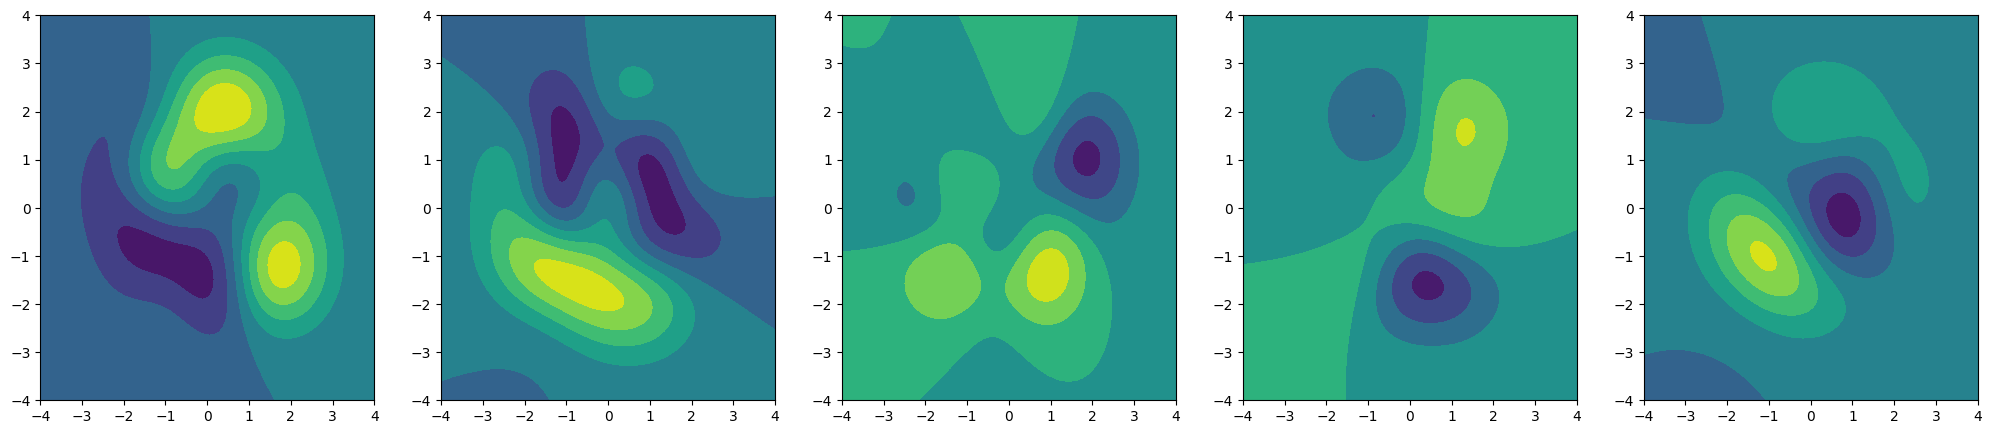

In [3]:
%matplotlib inline

fig, ax = plt.subplots(1, 5, figsize=(25, 5))

for i, v in enumerate(batch_out):
    ax[i].contourf(x, y, v.reshape(100, 100))

plt.show()

### Non-Stationary Functions using Procedurally Generated Parameters

Below we provide an example on how to create non-stationary functions through our API. The idea that we use is to maintain a counter within the `haiku.State` container that is incremented at every individual function call, over time this counter interpolates between two distinct sets of `haiku.Parameter` containers in order to shift the optimum around. These distinct sets of parameters are created through `hk.initializers.RandomUniform` in the `Translation` wrapper. Even though we do not make use of it here, note that the factories `bbox.as_callable` and `bbox.as_transformed` are also compatible with stateful base functions or wrappers by explicitly passing the `stateful=True` keyword argument.

In [4]:
from bbox.utils import trianglewave

from bbox import functions as fx


# Define our base function.
my_fun = as_transformed(
    base=fx.real.Ellipsoid,
    wrappers=[
        wx.real.Translation.partial(
            x_shift_init=hk.initializers.RandomUniform(-4.0, 4.0),  # procgen
            y_shift=0.0
        ),
        wx.real.UniformRotation,
        wx.real.WhiteNoise.partial(stddev=0.1)
    ],  
    register_optimum=True
)

time_period = 20


@hk.transform_with_state
def lerped(x: jax.Array) -> jax.Array:
    t = hk.get_state('t', shape=(), dtype=jnp.float32, init=jnp.zeros)

    param_start = hk.lift(my_fun.init, name='base_start')(hk.next_rng_key(), x)
    param_end = hk.lift(my_fun.init, name='base_end')(hk.next_rng_key(), x)

    # Extract parameter sub-container that can be conveniently lerped.
    modules = [wx.real.Translation.__name__]
    lerp_start, _ = hk.data_structures.partition(lambda m, n, v: any(s in m for s in modules), param_start)
    lerp_end, _ = hk.data_structures.partition(lambda m, n, v: any(s in m for s in modules), param_end)

    p = trianglewave(t, period=time_period)  # Oscilates linearly between t=0 and t=1.
    lerped_param = jax.tree_map(lambda a, b: b * p + (1 - p) * a, lerp_start, lerp_end)

    # Override the parameters in param_start with the interpolated parameters.
    param = hk.data_structures.merge(param_start, lerped_param)
    hk.set_state('t', t + 1.0)
    
    return my_fun.apply(param, hk.next_rng_key(), x) * 10


key = jax.random.PRNGKey(0)
key, key_init = jax.random.split(key)

params, state = lerped.init(key_init, jnp.zeros(2))

In [5]:
# Example of the haiku.State container
print(state)

{'~': {'t': Array(0., dtype=float32)}}


In [6]:
x = y = jnp.linspace(-5, 5, 100)
XY = jnp.asarray(jnp.meshgrid(x, y)).reshape(2, -1).T

key_array = jax.random.split(key, num=len(XY))
batch_lerped = jax.vmap(lerped.apply, in_axes=(None, None, 0, 0), out_axes=(0, None))

out, new_state = batch_lerped(params, state, key_array, XY)

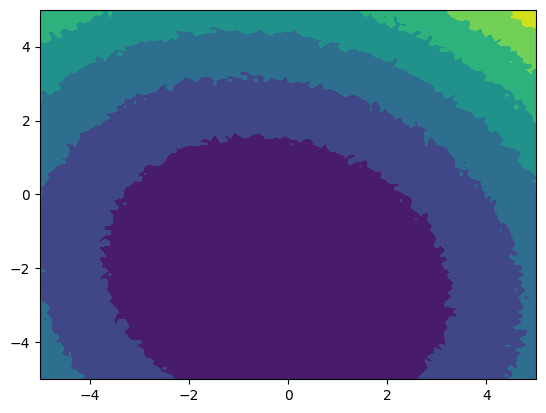

In [7]:
%matplotlib inline

plt.contourf(x, y, out.reshape(100, 100))
plt.show()

### Visualize Function over Time

Since our lerped funtion linearly interpolates the two sampled parameter containers over the time/ counter state, we expect the center of our sphere function to shift back and forth once over time, we can simulate this as shown below:

In [8]:
def body(carry, x=None):
    key, state = carry
    
    key_carry, key_apply = jax.random.split(key)
    key_array = jax.random.split(key_apply, len(XY))
    
    out, state = batch_lerped(params, state, key_array, XY)
    
    return (key_carry, state), out


_, data = jax.lax.scan(body, (key, state), None, length=time_period)

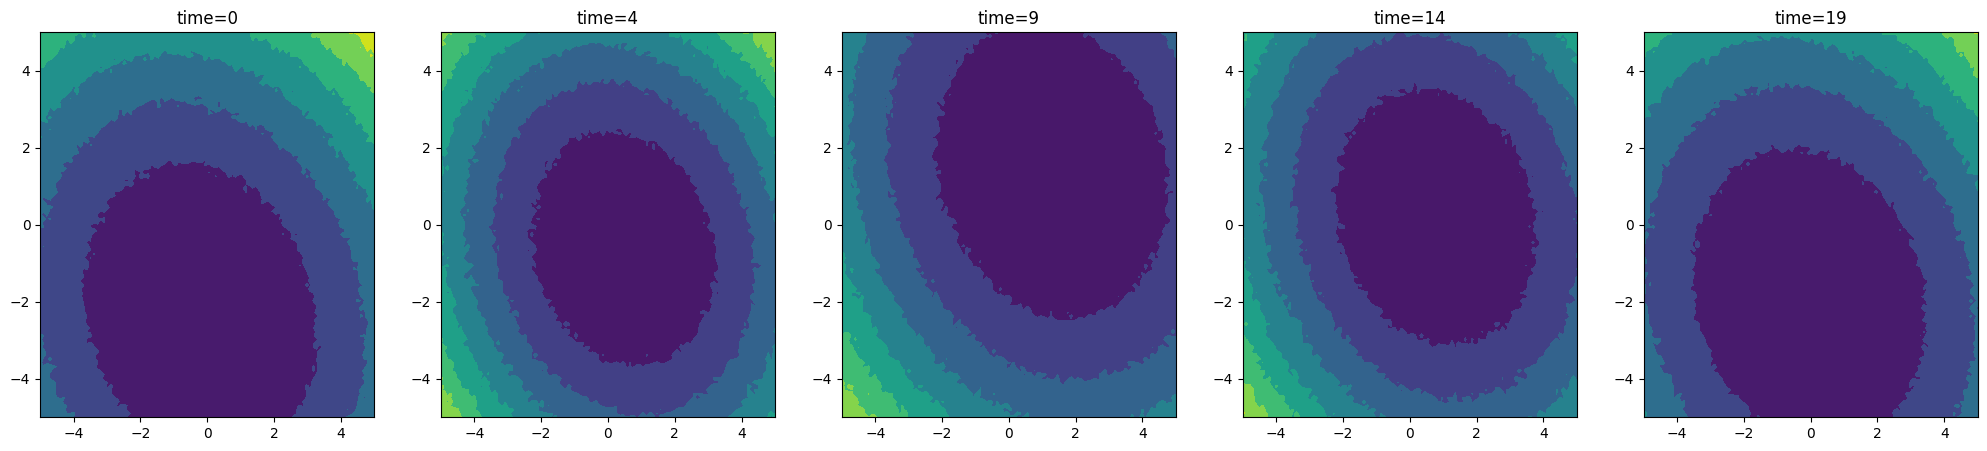

In [9]:
num = 5

fig, ax = plt.subplots(1, num, figsize=(5*num, 5))

indices = jnp.linspace(0, len(data) - 1, num).astype(int)
index_set = set(indices.tolist())

c = 0
for i, v in enumerate(data):
    if i in index_set:
        ax[c].contourf(x, y, v.reshape(100, 100))
        ax[c].set_title(f'time={i}')
        c += 1
        
plt.show()